##### Copyright 2018 Verily Life Sciences LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Default title text
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This notebook demonstrates how one can dive deeper into QC results to explain some unexpected patterns. In this notebook, we will see that a few samples in the [Platinum Genomes](https://cloud.google.com/genomics/docs/public-datasets/illumina-platinum-genomes) have a very low number of private variants, and we will figure out why.

> Eberle, MA et al. (2017) **A reference data set of 5.4 million phased human variants validated by genetic inheritance from sequencing a three-generation 17-member pedigree.** Genome Research 27: 157-164. [doi:10.1101/gr.210500.116](http://dx.doi.org/10.1101/gr.210500.116)

# Setup

Check out the code for the various QC methods.

In [0]:
!git clone https://github.com/verilylifesciences/variant-qc.git

Install additional Python dependencies [plotnine](https://plotnine.readthedocs.io/en/stable/) for plotting and [jinja2](http://jinja.pocoo.org/docs/2.10/) for performing text replacements in the SQL templates.

In [0]:
!pip install --upgrade plotnine jinja2

In [0]:
import jinja2
import numpy as np
import os
import pandas as pd
from plotnine import *

In [0]:
# Change this to be your project id.
PROJECT_ID = 'your-project-id'  #@param

In [0]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
def run_query(sql_template, replacements={}):
    if os.path.isfile(sql_template):
        sql_template = open(sql_template, "r").read()
    sql = jinja2.Template(sql_template).render(replacements)
    print('SQL to be executed:\n', sql)
    df = pd.io.gbq.read_gbq(sql, project_id=PROJECT_ID, dialect='standard')
    print('\nResult shape:\t', df.shape)
    return df

# Get a count of private variants

## Compute the private variant counts BigQuery

Running this query is optional as this has already been done and saved to Cloud Storage. See the next section for how to retrieve these results from Cloud Storage.

In [0]:
df = run_query(
    sql_template=os.path.join(os.environ['HOME'], 'variant-qc/sql/private_variants.sql'),
    replacements={
        'GENOME_CALL_OR_MULTISAMPLE_VARIANT_TABLE': 'bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823',
        'HIGH_QUALITY_CALLS_FILTER': 'NOT EXISTS (SELECT ft FROM UNNEST(c.FILTER) ft WHERE ft NOT IN ("PASS", "."))'
    }
)

SQL to be executed:
 #standardSQL
--
-- Compute private variants counts for each sample.
--
WITH filtered_called_alleles AS (
  SELECT
    reference_name,
    start_position,
    reference_bases AS ref,
    a.alt,
    c.name
  FROM
    `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` AS v,
    UNNEST(v.call) AS c,
    UNNEST(v.alternate_bases) AS a WITH OFFSET alt_offset
  WHERE
    EXISTS (SELECT g FROM UNNEST(c.genotype) AS g WHERE g = alt_offset+1)
    # Include only high quality calls.
    AND NOT EXISTS (SELECT ft FROM UNNEST(c.FILTER) ft WHERE ft NOT IN ("PASS", "."))
),

grouped_alleles AS (
  SELECT
    reference_name,
    start_position,
    ref,
    alt,
    STRING_AGG(name) AS name,
    COUNT(name) AS num_samples_with_variant
  FROM filtered_called_alleles
  GROUP BY
    reference_name,
    start_position,
    ref,
    alt
)

SELECT
  name,
  COUNT(name) AS private_variant_count
FROM grouped_alleles
WHERE
  num_samples_with_variant 

## Retrieve the private variant counts from Cloud Storage

We can read these values from the CSV created via [Sample-Level-QC.Rmd](https://github.com/verilylifesciences/variant-qc/blob/master/R/Sample-Level-QC.Rmd).

In [0]:
df = pd.read_csv("https://storage.googleapis.com/genomics-public-data/platinum-genomes/other/reports/DeepVariant_Platinum_Genomes_sample_results.csv")[["name", "private_variant_count"]]
df.shape

## Examine results and outliers

This small cohort does not contain enough samples to estimate the expected number of private variants. It is used here for demonstration purposes only.

In [0]:
df

,name,private_variant_count
0,NA12890,392743
1,NA12892,378972
2,NA12889,371670
3,NA12891,353934
4,NA12877,87153
5,NA12878,84171


Let's take a look at the samples who are more than one standard deviation away from the mean.

In [0]:
df.loc[abs(df.private_variant_count - df.private_variant_count.mean()) > df.private_variant_count.std(), :]

,name,private_variant_count
4,NA12877,87153
5,NA12878,84171


Next let's see if the sample metadata can be used to help explain the explain the low number of private variants that we see.

# Retrieve sample metadata

The platinum genomes samples are also members of the larger 1000 genomes dataset. We can retrieve the metadata for those samples from the 1000 genomes metadata.

In [0]:
metadata_df = run_query(
    sql_template="""
SELECT
  Sample AS name,
  Gender AS sex,
  Super_Population AS ancestry,
  Relationship AS relationship
FROM
  `bigquery-public-data.human_genome_variants.1000_genomes_sample_info`
WHERE
  Sample IN ('NA12877', 'NA12878', 'NA12889', 'NA12890', 'NA12891', 'NA12892')
  """
)

SQL to be executed:
 
SELECT
  Sample AS name,
  Gender AS sex,
  Super_Population AS ancestry,
  Relationship AS relationship
FROM
  `bigquery-public-data.human_genome_variants.1000_genomes_sample_info`
WHERE
  Sample IN ('NA12877', 'NA12878', 'NA12889', 'NA12890', 'NA12891', 'NA12892')
  

Result shape:	 (6, 4)


# Visualize results by ancestry

In [0]:
joined_results = pd.merge(df, metadata_df, how='left', on='name')
joined_results.shape

(6, 5)

In [0]:
assert(joined_results.shape == (6, 5))

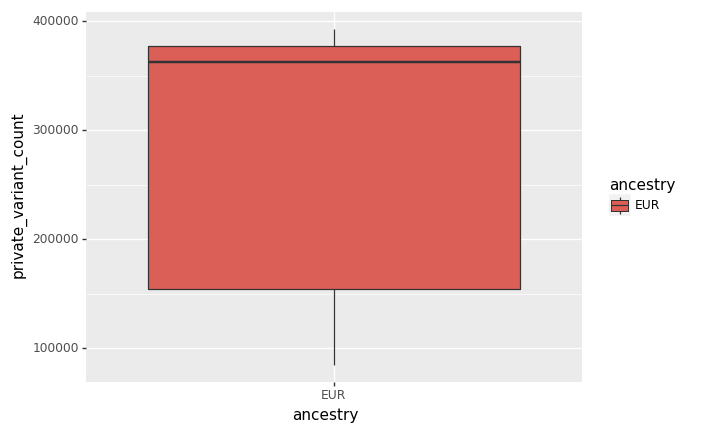

<ggplot: (8749801556386)>

In [0]:
p = (ggplot(joined_results) +
     geom_boxplot(aes(x = 'ancestry', y = 'private_variant_count', fill = 'ancestry'))
    )
p

All individuals in this dataset are of the same ancestry, so that does not explain the pattern we see.

# Visualize results by relationship

We know from [the paper](https://genome.cshlp.org/content/27/1/157) that all members of this cohort are from the same family.

In [0]:
run_query("""
SELECT
  *
FROM
  `bigquery-public-data.human_genome_variants.1000_genomes_pedigree`
WHERE
  Individual_ID IN ('NA12877', 'NA12878', 'NA12889', 'NA12890', 'NA12891', 'NA12892')
""")

SQL to be executed:
 
SELECT
  *
FROM
  `bigquery-public-data.human_genome_variants.1000_genomes_pedigree`
WHERE
  Individual_ID IN ('NA12877', 'NA12878', 'NA12889', 'NA12890', 'NA12891', 'NA12892')

Result shape:	 (6, 12)


,Family_ID,Individual_ID,Paternal_ID,Maternal_ID,Gender,Phenotype,Population,Relationship,Siblings,Second_Order,Third_Order,Other_Comments
0,1463,NA12877,NA12889,NA12890,1,0,CEU,father; child,0,0,0,0
1,1463,NA12889,0,0,1,0,CEU,pat grandfather; father,0,0,0,0
2,1463,NA12891,0,0,1,0,CEU,mat grandfather; father,0,0,0,0
3,1463,NA12878,NA12891,NA12892,2,0,CEU,mother; child,0,0,0,0
4,1463,NA12890,0,0,2,0,CEU,pat grandmother; mother,0,0,0,0
5,1463,NA12892,0,0,2,0,CEU,mat grandmother; mother,0,0,0,0


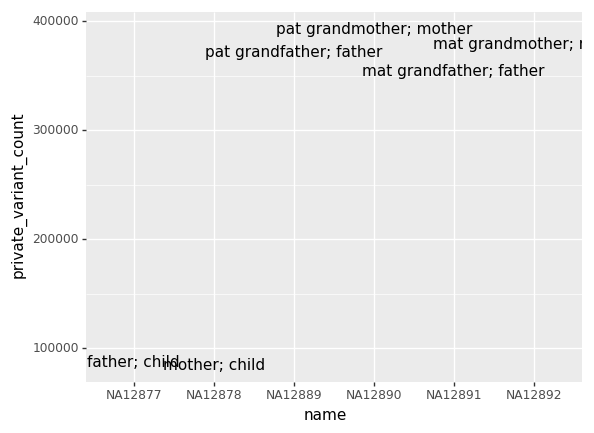

<ggplot: (-9223363287053216775)>

In [0]:
p = (ggplot(joined_results) +
     geom_text(aes(x = 'name', y = 'private_variant_count', label = 'Relationship'))
    )
p

And we can see that the relationship between individuals explains the pattern we see in the private variant counts.